In [1]:
# %pip install python-louvain
# %pip install infomap
# %pip install plotly
# %pip install nbformat>=4.2.0

In [2]:
%load_ext autoreload
%aimport utils.utils
%aimport utils.actor
%aimport utils.transaction
%autoreload 1

In [3]:
import pandas as pd
import os

import community as community_louvain

from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from community import community_louvain
from scipy.stats import pearsonr, spearmanr

from networkx.algorithms.community import greedy_modularity_communities

from utils.utils import load_all_csv_in_dir
from utils.utils import create_transaction_graph_from_dataframe
from utils.actor import Actor

# Load Data

Read the daily transaction network files (YYYY-MM-DD.csv) into a format suitable for analysis (e.g., pandas DataFrame if you're using Python). Explore the structure of the data to ensure it matches the provided description.


In [4]:
data_dir = "../data/networks/"

transaction_features_df = load_all_csv_in_dir(data_dir)
transaction_features_df = transaction_features_df.sort_values(by="date").reset_index(drop=True)

print(transaction_features_df.shape)
transaction_features_df.head()

(5876734, 5)


,Source,Target,value,nb_transactions,date
0,73937548,69565876,70039010,1,2015-01-01
1,ePay.info_CoinJoinMess,Betcoin.ag,31190000,6,2015-01-01
2,BTC-e.com,Cryptsy.com,4397385506,6,2015-01-01
3,ePay.info_CoinJoinMess,Bleutrade.com,18176239,1,2015-01-01
4,Cryptsy.com,Loanbase.com,24888230,1,2015-01-01


# Community Detection

Apply community detection algorithms to identify communities within each daily transaction network. Consider using libraries like NetworkX (Python) for this task. Common community detection algorithms include Louvain method, Girvan-Newman algorithm, and the Infomap algorithm.


In [5]:
transaction_features_df = transaction_features_df.head(100000)
transaction_features_df.shape

(100000, 5)

In [6]:
G = create_transaction_graph_from_dataframe(transaction_features_df)

In [7]:
communities = list(greedy_modularity_communities(G))

First of all we will create a dataframe with the informations of each actor of the network. We will store the number of transactions/unique transactions and the total amount of money sent/received by each actor as well as the total volume.

In [8]:
actors_names = sorted(list(set(transaction_features_df["Source"].unique()).union(set(transaction_features_df["Target"].unique()))), reverse=True)
actors_community = {actor: i for i, c in enumerate(communities) for actor in c}

actors = [Actor(name, actors_community[name]) for name in actors_names]

In [9]:
for _, row in transaction_features_df.iterrows():
    source = row["Source"]
    target = row["Target"]
    weight = row["value"]
    nb_transactions = row["nb_transactions"]

    source_actor = next(actor for actor in actors if actor.name == source)
    target_actor = next(actor for actor in actors if actor.name == target)

    source_actor.process_transaction(target_actor, weight, nb_transactions, row["date"])

In [ ]:
top_10_actors = sorted(actors, key=lambda a: a.get_total_volume(), reverse=True)[:10]

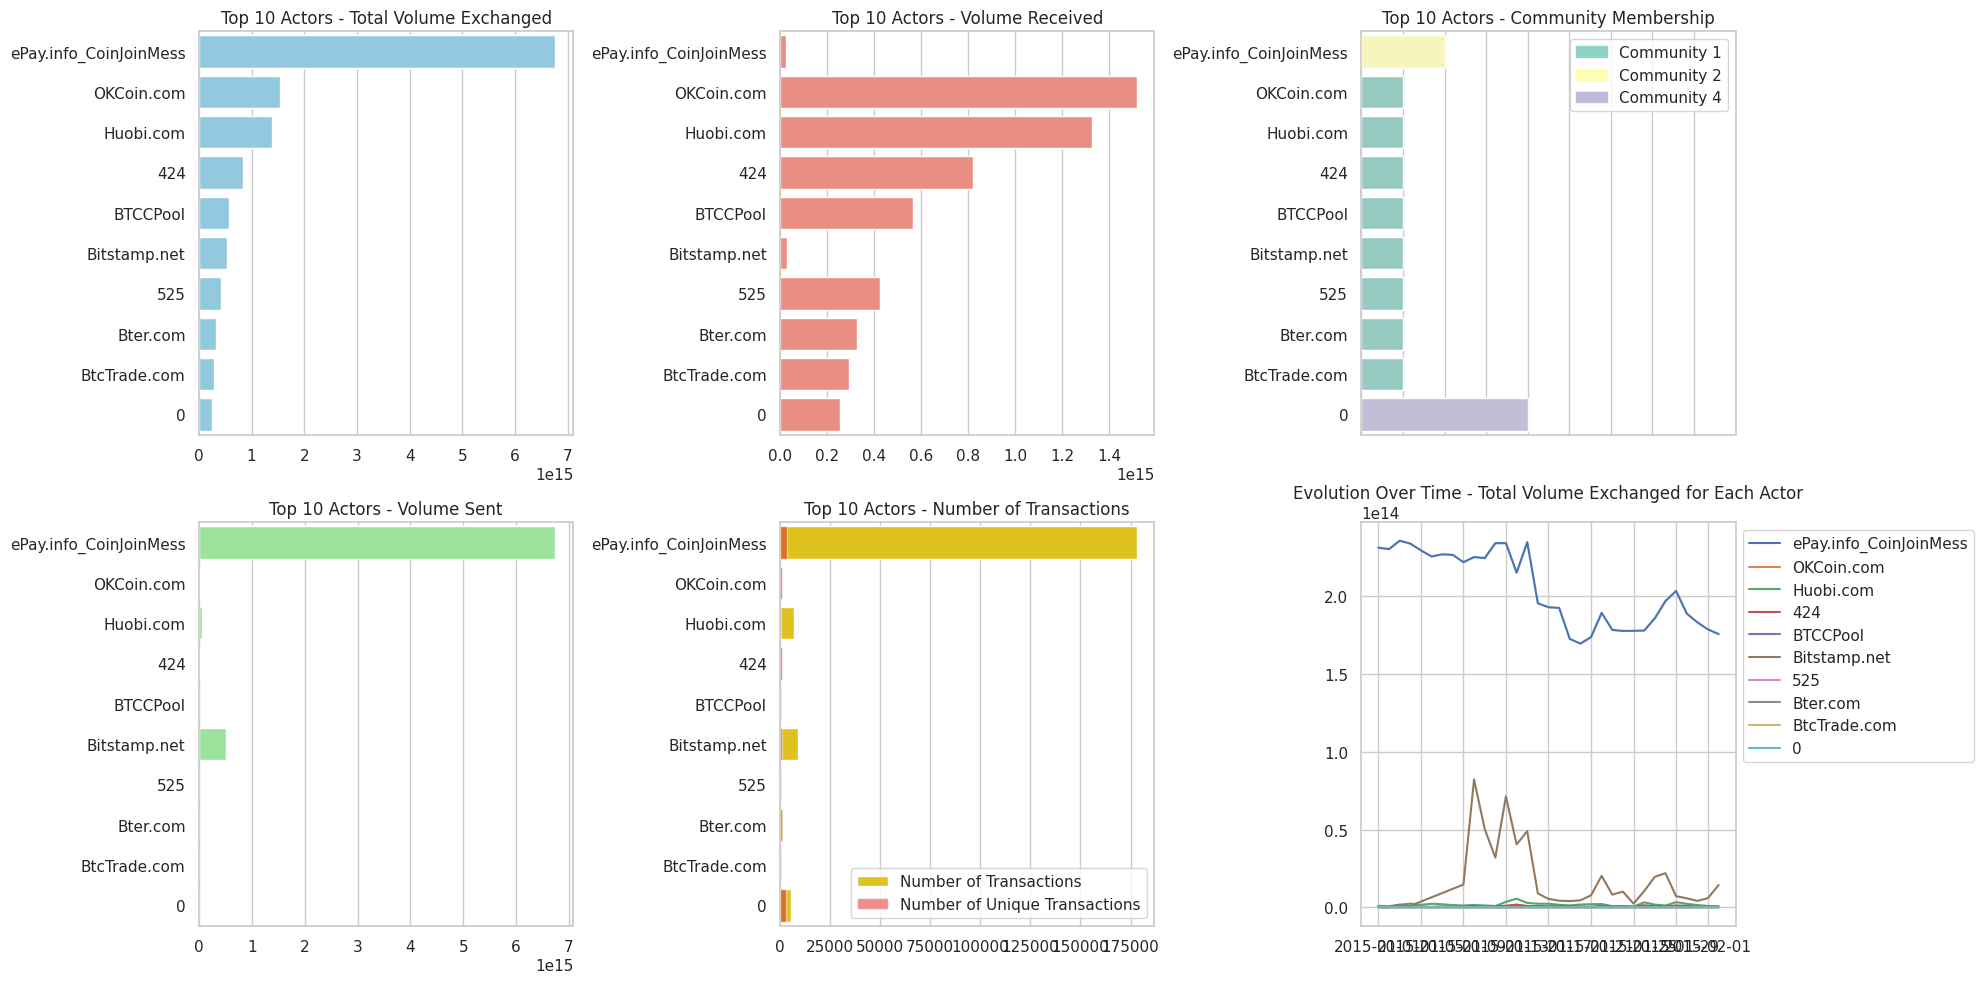

In [42]:
sns.set(style="whitegrid")

TOP_N_ACTORS = 10

top_10_actors = sorted(actors, key=lambda a: a.get_total_volume(), reverse=True)[:TOP_N_ACTORS]
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

actors_names = list(map(lambda actor: actor.get_name(), top_10_actors))

# Plot total volume
sns.barplot(x=list(map(lambda actor: actor.get_total_volume(), top_10_actors)), y=actors_names, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Top 10 Actors - Total Volume Exchanged')

# Plot volume received
sns.barplot(x=list(map(lambda actor: actor.get_volume_received(), top_10_actors)), y=actors_names, color='salmon', ax=axes[0, 1])
axes[0, 1].set_title(F'Top {TOP_N_ACTORS} Actors - Volume Received')

# Plot volume sent
sns.barplot(x=list(map(lambda actor: actor.get_volume_sended(), top_10_actors)), y=actors_names, color='lightgreen', ax=axes[1, 0])
axes[1, 0].set_title(F'Top {TOP_N_ACTORS} Actors - Volume Sent')

# Plot number of transactions with unique transactions in lower opacity
sns.barplot(x=list(map(lambda actor: actor.get_nb_transactions(), top_10_actors)), y=actors_names, color='gold', ax=axes[1, 1], label='Number of Transactions')
sns.barplot(x=list(map(lambda actor: actor.get_nb_unique_transactions(), top_10_actors)), y=actors_names, color='red', alpha=0.5, ax=axes[1, 1], label='Number of Unique Transactions')
axes[1, 1].set_title(F'Top {TOP_N_ACTORS} Actors - Number of Transactions')

actors_community = list(map(lambda actor: actor.get_community(), top_10_actors))

# Plot actor community with color mapping
community_palette = sns.color_palette("Set3", n_colors=len(set(actors_community)))
sns.barplot(x=actors_community, y=actors_names, palette=community_palette, ax=axes[0, 2], hue=actors_community)

axes[0, 2].set_title(F'Top {TOP_N_ACTORS} Actors - Community Membership')
axes[0, 2].set_xticks(range(len(actors_names)))

# Add legend for community colors
legend_labels = sorted([f"Community {i}" for i in set(actors_community)])
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=community_palette[i]) for i in range(len(legend_labels))]
axes[0, 2].legend(handles=legend_handles, labels=legend_labels, loc='upper right')
axes[0, 2].set_xticklabels([])

# Plot the evolution over time of the total volume exchanged for each actor
for actor in top_10_actors:
    volume_by_day = actor.get_transactions_volume_by_day()
    sns.lineplot(x=[t.date for t in volume_by_day], y=[t.value for t in volume_by_day], label=actor.get_name(), ax=axes[1, 2])

axes[1, 2].set_title('Evolution Over Time - Total Volume Exchanged for Each Actor')
axes[1, 2].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [43]:
for actor in actors[:TOP_N_ACTORS]:
    actor.process_volume_by_day()

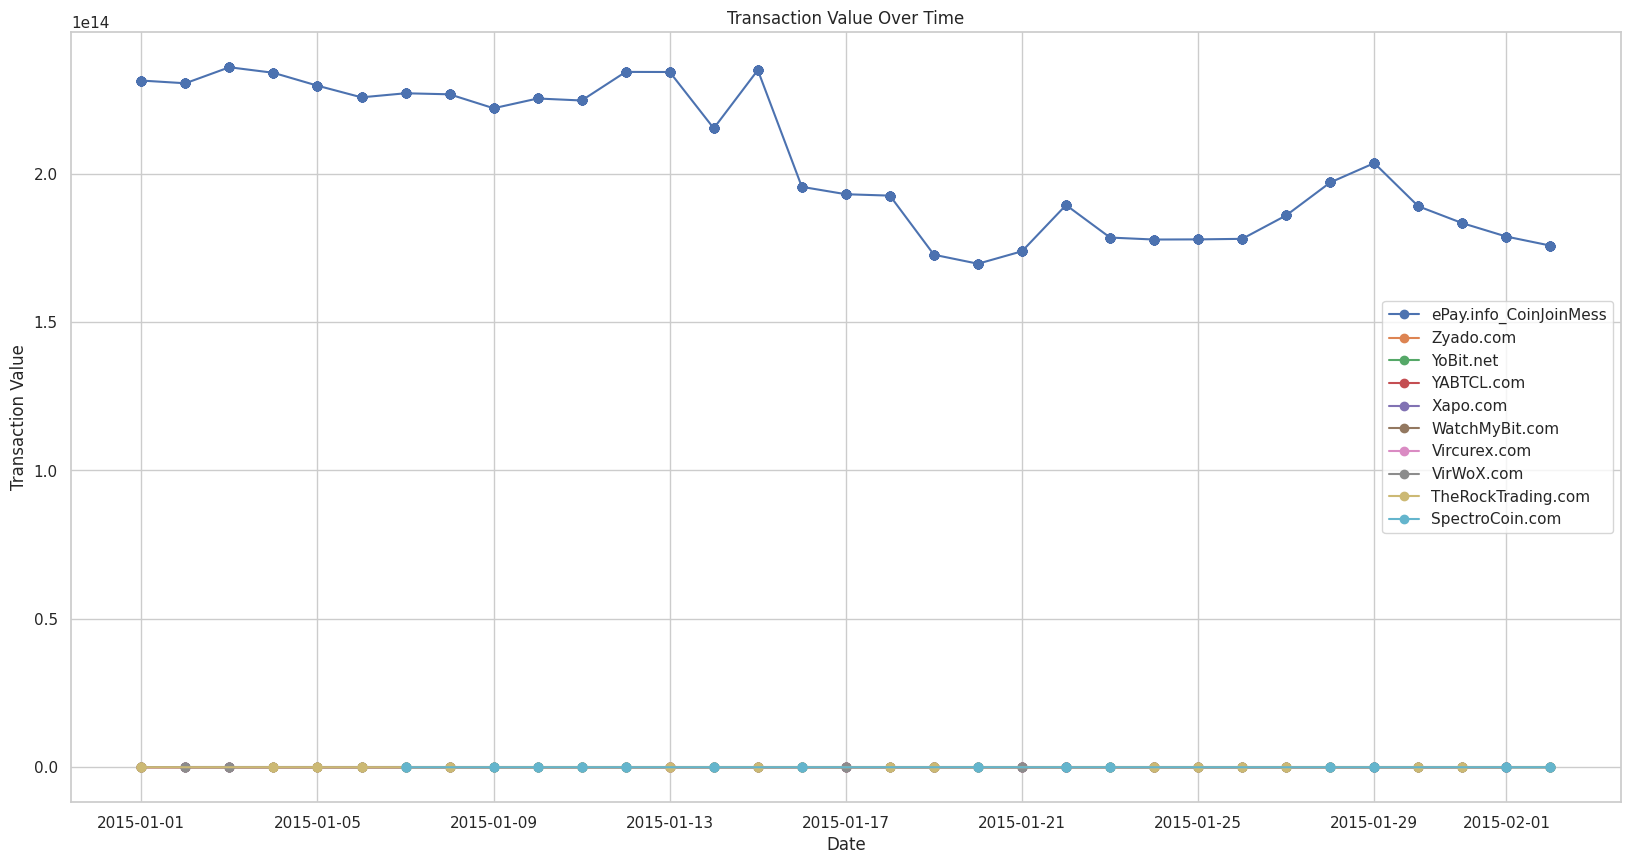

In [44]:
plt.figure(figsize=(20, 10))

for actor in actors[:TOP_N_ACTORS]:
    volume_by_day = actor.get_transactions_volume_by_day()
    plt.plot([t.date for t in volume_by_day], [t.value for t in volume_by_day], marker='o', linestyle='-', label=actor.get_name())

plt.xlabel('Date')
plt.ylabel('Transaction Value')
plt.title('Transaction Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
members = [sorted(c, reverse=True) for c in communities]

total_volumes_per_community = [sum(G.degree(n, weight="weight") for n in c) for c in communities]
total_volumes_received_per_community = [sum(actors_volume[n]["received"] for n in c) for c in communities]
total_volumes_sended_per_community = [sum(actors_volume[n]["sended"] for n in c) for c in communities]
total_nb_transactions_per_community = [sum(actors_volume[n]["nb_transactions"] for n in c) for c in communities]

nb_transactions_per_community = [sum(actors_volume[n]["nb_unique_transaction"] for n in c) for c in communities]

community_size = [len(c) for c in communities]
community_indices = ["Comunity " + str(i) for i in range(len(communities))]

communities_features_df = pd.DataFrame(
    {
        "community": community_indices,
        "members": members,
        "size": community_size,
        "total_volume": total_volumes_per_community,
        "total_volume_received": total_volumes_received_per_community,
        "total_volume_sended": total_volumes_sended_per_community,
        "nb_transactions": total_nb_transactions_per_community,
        "nb_unique_transactions": nb_transactions_per_community,
    }
)

communities_features_df.sort_values(by="total_volume", ascending=False).head(10)

In [ ]:
# Set a professional style using seaborn
sns.set(style="whitegrid")

TOP_N_COMMUNITIES = 5
top_10_communities = communities_features_df.sort_values(by="total_volume", ascending=False).head(TOP_N_COMMUNITIES)
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Plot total volume per community
sns.barplot(x=top_10_communities["total_volume"], y=top_10_communities["community"], color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title(f'Top {TOP_N_COMMUNITIES} Communities - Total Volume Exchanged')

# Plot total volume received per community
sns.barplot(x=top_10_communities["total_volume_received"], y=top_10_communities["community"], color='salmon', ax=axes[0, 1])
axes[0, 1].set_title(f'Top {TOP_N_COMMUNITIES} Communities - Total Volume Received')

# Plot total volume sent per community
sns.barplot(x=top_10_communities["total_volume_sended"], y=top_10_communities["community"], color='lightgreen', ax=axes[1, 0])
axes[1, 0].set_title(f'Top {TOP_N_COMMUNITIES} Communities - Total Volume Sent')

# Plot number of transactions per community with unique transactions in lower opacity
sns.barplot(x=top_10_communities["nb_transactions"], y=top_10_communities["community"], color='gold', ax=axes[1, 1], label='Number of Transactions')
sns.barplot(x=top_10_communities["nb_unique_transactions"], y=top_10_communities["community"], color='red', alpha=0.5, ax=axes[1, 1], label='Number of Unique Transactions')
axes[1, 1].set_title(f'Top {TOP_N_COMMUNITIES} Communities - Number of Transactions')

# Plot the size of the communities
sns.barplot(x=top_10_communities["size"], y=top_10_communities["community"], color='orange', ax=axes[0, 2])
axes[0, 2].set_title(f'Top {TOP_N_COMMUNITIES} Communities - Size')

# Plot the evolution over time of the total volume exchanged for each community
for community in top_10_communities["community"]:
    community_data = transaction_features_df[transaction_features_df["Source"].isin(communities_features_df[communities_features_df["community"] == community]["members"].values[0])]
    sns.lineplot(x=community_data["date"], y=community_data["value"], label=community, ax=axes[1, 2])
    
axes[1, 2].set_title(f'Evolution Over Time - Total Volume Exchanged for Each Community')
axes[1, 2].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [ ]:
transaction_features_df

In [ ]:
def get_community_evolution():
    data = []
    for community in top_10_communities["community"]:
        community_data = transaction_features_df[transaction_features_df["Source"].isin(communities_features_df[communities_features_df["community"] == community]["members"].values[0])]
        data.append({community: community_data})
    
    return data


In [ ]:
plt.figure(figsize=(20, 10))

# Iterate through each community's data
for community_data in get_community_evolution():
    for community_name, community_df in community_data.items():
        community_df = community_df.groupby("date")["value"].sum().reset_index()
        # Plot the community's volume over time
        plt.plot(community_df["date"], community_df["value"], label=community_name)

# Customize the plot
plt.xlabel('Timestamp')
plt.ylabel('Volume')
plt.title('Evolution of Community Volumes Over Time')
plt.legend()
plt.show()

# Evolution of Community Structure

Track the evolution of community structure over time. For each day, identify the number of communities, their sizes, or any other relevant metrics. Visualize the changes in community structure over time to observe patterns or trends.

In [ ]:
# Initialize an empty dictionary to store the community structure evolution
community_structure_evolution = {}

# Import the community_louvain module from the community package

# Loop through each date
for date in sample["date"].unique():
    # Filter the data for the current date
    date_data = all_data[all_data["date"] == date]

    # Create a graph from the date data
    G_date = nx.from_pandas_edgelist(date_data, "Source", "Target", edge_attr=True)

    # Apply the Louvain method for community detection
    partition_date = community_louvain.best_partition(G_date)

    # Count the number of communities and their sizes
    community_counts = pd.Series(partition_date).value_counts().to_dict()

    # Store the community structure for the current date
    community_structure_evolution[date] = community_counts

# Convert the dictionary to a dataframe
community_structure_df = pd.DataFrame.from_dict(
    community_structure_evolution, orient="index"
)

# Fill NaN values with 0
community_structure_df.fillna(0, inplace=True)

# Plot the evolution of community structure over time
plt.figure(figsize=(10, 6))
for column in community_structure_df.columns:
    plt.plot(
        community_structure_df.index,
        community_structure_df[column],
        label=f"Community {column}",
    )

plt.xlabel("Date")
plt.ylabel("Community Size")
plt.title("Evolution of Community Structure Over Time")
plt.legend()
plt.show()

# Bitcoin Price Data Integration

Integrate the Bitcoin price data with the community structure data. Ensure that both datasets are aligned by date. You can merge the transaction network data with the Bitcoin price data based on the common date column.


In [ ]:
# Import the Bitcoin price data
bitcoin_price_data = pd.read_csv("/path/to/bitcoin/price/data.csv")

# Convert the 'Date' column to datetime format
bitcoin_price_data["Date"] = pd.to_datetime(bitcoin_price_data["Date"])

# Merge the community structure data with the Bitcoin price data
merged_data = pd.merge(
    community_structure_df, bitcoin_price_data, left_index=True, right_on="Date"
)

# Display the first few rows of the merged dataframe to check its structure
merged_data.head()

# Correlation Analysis

Examine the correlation between the evolution of the community structure metrics (e.g., number of communities, community sizes) and the Bitcoin prices over time. Use statistical measures (e.g., correlation coefficients) to quantify the relationship.


In [ ]:
# Initialize empty lists to store correlation results
pearson_correlations = []
spearman_correlations = []

# Loop through each community
for column in community_structure_df.columns:
    # Calculate the Pearson correlation coefficient between the community size and the Bitcoin price
    pearson_corr, _ = pearsonr(merged_data[column], merged_data["Price"])
    pearson_correlations.append(pearson_corr)

    # Calculate the Spearman correlation coefficient between the community size and the Bitcoin price
    spearman_corr, _ = spearmanr(merged_data[column], merged_data["Price"])
    spearman_correlations.append(spearman_corr)

# Create a dataframe to store the correlation results
correlation_df = pd.DataFrame(
    {
        "Community": community_structure_df.columns,
        "Pearson Correlation": pearson_correlations,
        "Spearman Correlation": spearman_correlations,
    }
)

# Display the correlation results
correlation_df

# Plot the correlation results
plt.figure(figsize=(10, 6))
plt.bar(
    correlation_df["Community"],
    correlation_df["Pearson Correlation"],
    label="Pearson Correlation",
)
plt.bar(
    correlation_df["Community"],
    correlation_df["Spearman Correlation"],
    label="Spearman Correlation",
    alpha=0.5,
)
plt.xlabel("Community")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation Between Community Size and Bitcoin Price")
plt.legend()
plt.show()

# Visualization

Create visualizations to represent the daily transaction networks with detected communities. Additionally, generate time series plots for Bitcoin prices and community structure metrics. Visualize any patterns or anomalies that may be observed.


In [ ]:
# Set the style of the plots
sns.set_style("whitegrid")

# Plot the daily transaction networks with detected communities
plt.figure(figsize=(10, 6))
nx.draw(
    G,
    with_labels=False,
    node_color=list(partition.values()),
    cmap=plt.cm.RdYlBu,
    node_size=50,
    alpha=0.6,
)
plt.title("Daily Transaction Networks with Detected Communities")
plt.show()

# Plot the time series of Bitcoin prices
plt.figure(figsize=(10, 6))
plt.plot(bitcoin_price_data["Date"], bitcoin_price_data["Price"], label="Bitcoin Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Time Series of Bitcoin Prices")
plt.legend()
plt.show()

# Plot the time series of community structure metrics
plt.figure(figsize=(10, 6))
for column in community_structure_df.columns:
    plt.plot(
        community_structure_df.index,
        community_structure_df[column],
        label=f"Community {column}",
    )
plt.xlabel("Date")
plt.ylabel("Community Size")
plt.title("Time Series of Community Structure Metrics")
plt.legend()
plt.show()

# Plot the correlation results
plt.figure(figsize=(10, 6))
plt.bar(
    correlation_df["Community"],
    correlation_df["Pearson Correlation"],
    label="Pearson Correlation",
)
plt.bar(
    correlation_df["Community"],
    correlation_df["Spearman Correlation"],
    label="Spearman Correlation",
    alpha=0.5,
)
plt.xlabel("Community")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation Between Community Size and Bitcoin Price")
plt.legend()
plt.show()

# Visualize the anomalies in the Bitcoin price data
plt.figure(figsize=(10, 6))
sns.boxplot(bitcoin_price_data["Price"])
plt.title("Boxplot of Bitcoin Prices")
plt.show()

# Hypothesis Testing

Formulate hypotheses about the potential relationship between the evolution of the community structure and Bitcoin prices. If the correlation is observed, perform hypothesis testing to assess the significance of the relationship.


In [ ]:
# Formulate the hypothesis
# Null Hypothesis (H0): There is no significant correlation between the evolution of the community structure and Bitcoin prices.
# Alternative Hypothesis (H1): There is a significant correlation between the evolution of the community structure and Bitcoin prices.

# Initialize an empty list to store p-values
p_values = []

# Loop through each community
for column in community_structure_df.columns:
    # Perform a t-test between the community size and the Bitcoin price
    t_stat, p_value = ttest_ind(merged_data[column], merged_data["Price"])
    p_values.append(p_value)

# Add the p-values to the correlation dataframe
correlation_df["p-value"] = p_values

# Display the correlation results with p-values
correlation_df

# Interpret the results
# If p-value < 0.05, we reject the null hypothesis and conclude that there is a significant correlation.
# If p-value >= 0.05, we fail to reject the null hypothesis and conclude that there is no significant correlation.
correlation_df["Significant Correlation"] = correlation_df["p-value"] < 0.05

# Display the final results
correlation_df